## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Getting the datasets

In [53]:
df=pd.read_csv("train.csv")

In [3]:
test=pd.read_csv('test.csv')

In [4]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [5]:
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#112213')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #000066; color: white;'
}

## Exploratory Data Analysis

In [54]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

# categorical
df['vendor_id'] = df['vendor_id'].astype(str) 
test['vendor_id'] = test['vendor_id'].astype(str) 

In [7]:
df.describe().style.format(precision=2, thousands=",", decimal=".").set_table_styles([cell_hover, index_names, headers])

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,"1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00"
mean,1.66,-73.97,40.75,-73.97,40.75,959.49
std,1.31,0.07,0.03,0.07,0.04,"5,237.43"
min,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,-73.97,40.77,-73.96,40.77,"1,075.00"
max,9.00,-61.34,51.88,-61.34,43.92,"3,526,282.00"


In [8]:
df.describe(include=['O']).style.format(precision=2, thousands=",", decimal=".").set_table_styles([cell_hover, index_names, headers])

,id,vendor_id,store_and_fwd_flag
count,"1,458,644","1,458,644","1,458,644"
unique,"1,458,644",2,2
top,id2875421,2,N
freq,1,"780,302","1,450,599"


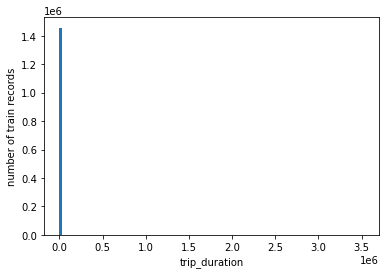

In [9]:
# check data distribution and if needed change it log data distribution
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

In [1]:
# Changing the data into a log data distribution
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
plt.hist(df['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

NameError: name 'np' is not defined

## Plotting the area points

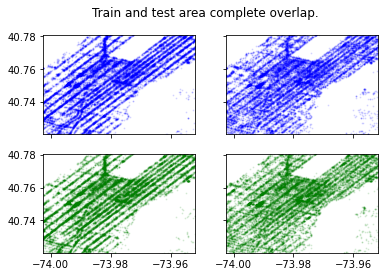

In [11]:
# Scatter Pickup Points
max_long = df['pickup_longitude'].quantile(0.9)
max_lat = df['pickup_latitude'].quantile(0.9)
min_long = df['pickup_longitude'].quantile(0.1)
min_lat = df['pickup_latitude'].quantile(0.1)

N = 30_000
city_long_border = (min_long, max_long)
city_lat_border = (min_lat, max_lat)
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
ax[0,0].scatter(df['pickup_longitude'].values[:N], df['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1,0].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
ax[0,1].scatter(df['dropoff_longitude'].values[:N], df['dropoff_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1,1].scatter(test['dropoff_longitude'].values[:N], test['dropoff_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [12]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
log_trip_duration     0
dtype: int64

### Now remove outliers

In [13]:
from scipy import stats
# select numerical variables only
numerical_variables = df.select_dtypes(include='number').columns

# Menentukan threshold untuk menandai potensi pencilan
# Menghitung threshold berdasarkan alpha 2.5%
threshold = stats.norm.ppf(1 - 0.025/2)

all_indices = []

print("Threshold (Z-score) untuk alpha 2.5%:", threshold, end='\n\n')

# Menghitung Z-score untuk atribut GrLivArea
for num_var in numerical_variables:
    z_scores = stats.zscore(df[num_var])

    # Mengidentifikasi indeks baris dengan nilai Z-score di atas threshold
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
    
    outliers_df = df.iloc[outlier_indices]
    non_outliers_df = df[~df.index.isin(outlier_indices)]

    # Menampilkan indeks baris dengan potensi pencilan
    print(f"Potensi Pencilan (Z-score) {num_var}: {len(outlier_indices)}")
    
    min_outliers = outliers_df[num_var].min()
    median_non_outliers = non_outliers_df[num_var].median()
    
    all_indices.extend(list(outlier_indices))
    
    # Menampilkan indeks baris dengan potensi pencilan
    print(f"Minimum value untuk outliers : {min_outliers}, median non outliers : {median_non_outliers}", end='\n\n')
    
all_indices = list(set(all_indices))
print(len(all_indices), df.shape[0])

Threshold (Z-score) untuk alpha 2.5%: 2.241402727604947

Potensi Pencilan (Z-score) passenger_count: 126426
Minimum value untuk outliers : 5, median non outliers : 1.0

Potensi Pencilan (Z-score) pickup_longitude: 33321
Minimum value untuk outliers : -121.93334197998048, median non outliers : -73.9820785522461

Potensi Pencilan (Z-score) pickup_latitude: 40658
Minimum value untuk outliers : 34.35969543457031, median non outliers : 40.75493621826172

Potensi Pencilan (Z-score) dropoff_longitude: 21537
Minimum value untuk outliers : -121.9333038330078, median non outliers : -73.98000335693358

Potensi Pencilan (Z-score) dropoff_latitude: 47887
Minimum value untuk outliers : 32.1811408996582, median non outliers : 40.75489044189453

Potensi Pencilan (Z-score) trip_duration: 2089
Minimum value untuk outliers : 12909, median non outliers : 662.0

Potensi Pencilan (Z-score) log_trip_duration: 31897
Minimum value untuk outliers : 0.6931471805599453, median non outliers : 6.505784060128229

22

<AxesSubplot:>

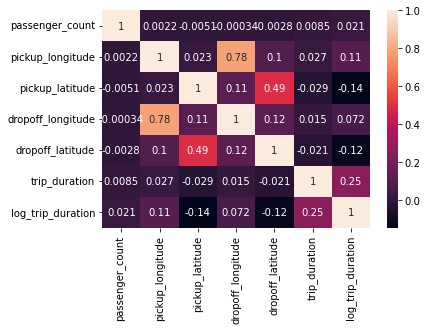

In [14]:
# Check correlation
c_ = df.select_dtypes(include='number').corr()
sns.heatmap(c_,annot=True)

In [55]:
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]

print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [56]:
df['store_and_fwd_flag'] = np.where(df.store_and_fwd_flag.values == 'Y', 1, 0 )
test['store_and_fwd_flag'] = np.where(test.store_and_fwd_flag.values == 'Y', 1, 0 )

C:\Users\vardh\AppData\Local\Temp\ipykernel_21800\3980181527.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  test['store_and_fwd_flag'] = np.where(test.store_and_fwd_flag.values == 'Y', 1, 0 )


### Feature Engineering

In [57]:
# Day of the week
df.loc[:, 'pickup_dotw'] = df['pickup_datetime'].dt.day_name()
test.loc[:, 'pickup_dotw'] = test['pickup_datetime'].dt.day_name()

# Month
df.loc[:, 'pickup_month'] = df['pickup_datetime'].dt.month_name()
test.loc[:, 'pickup_month'] = test['pickup_datetime'].dt.month_name()

# Quarter
df.loc[:, 'pickup_quarter'] = df['pickup_datetime'].dt.quarter
test.loc[:, 'pickup_quarter'] = test['pickup_datetime'].dt.quarter

# Is Weekend
df.loc[:, 'pickup_isweekend'] = df['pickup_datetime'].dt.dayofweek.isin([5,6])
test.loc[:, 'pickup_isweekend'] = test['pickup_datetime'].dt.dayofweek.isin([5,6])

# Is Events
# New Year's Day, Martin Luther King Jr. Day, Valentine's Day, Presidents' Day, St. Patrick's Day, Easter Sunday, Mother's Day, Memorial Day
important_events = ['2016-01-01', '2016-01-18', '2016-02-14', '2016-02-15',
                    '2016-03-17', '2016-03-27', '2016-05-08', '2016-05-30']
holidays = pd.to_datetime(important_events)
df.loc[:, 'pickup_isevents'] = df['pickup_datetime'].isin(holidays)
test.loc[:, 'pickup_isevents'] = test['pickup_datetime'].isin(holidays)

# Day of the Month
df.loc[:, 'pickup_dotm'] = df['pickup_datetime'].dt.strftime('%d')
test.loc[:, 'pickup_dotm'] = test['pickup_datetime'].dt.strftime('%d')

# Week of the Year
df.loc[:, 'pickup_woty'] = df['pickup_datetime'].dt.strftime('Week %U')
test.loc[:, 'pickup_woty'] = test['pickup_datetime'].dt.strftime('Week %U')

# Season
seasons = {1: 'Winter',2: 'Winter',3: 'Spring',4: 'Spring',5: 'Spring',6: 'Summer',7: 'Summer',8: 'Summer',9: 'Autumn',10: 'Autumn',
    11: 'Autumn',12: 'Winter'}
df.loc[:, 'pickup_season'] = df['pickup_datetime'].dt.month.map(seasons)
test.loc[:, 'pickup_season'] = test['pickup_datetime'].dt.month.map(seasons)

In [58]:
## from Longitude Latitude

# === Euclidean Distance ===
def euclidean_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2-lat1)**2 + (lon2-lon1)**2)

# Apply the function to the DataFrame
df['euclidean_distance'] = df.apply(lambda row: euclidean_distance(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
test['euclidean_distance'] = test.apply(lambda row: euclidean_distance(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# === Manhattan Distance ===
def manhattan_distance(lat1, lon1, lat2, lon2):
    return np.abs(lat2-lat1) + np.abs(lon2-lon1)

# Apply the function to the DataFrame
df['manhattan_distance'] = df.apply(lambda row: manhattan_distance(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
test['manhattan_distance'] = test.apply(lambda row: manhattan_distance(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [19]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # radius bumi dalam kilometer
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    distance = R * c
    return distance

# Apply the function to the DataFrame
df['haversine_distance'] = df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
test['haversine_distance'] = test.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [20]:
def bearing(lat1, lon1, lat2, lon2):
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    
    y = sin(dlon) * cos(lat2_rad)
    x = cos(lat1_rad) * sin(lat2_rad) - sin(lat1_rad) * cos(lat2_rad) * cos(dlon)
    
    bearing = atan2(y, x)
    return np.degrees(bearing)

# Apply the function to the DataFrame
df['bearing'] = df.apply(lambda row: bearing(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
test['bearing'] = test.apply(lambda row: bearing(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [21]:
df['diff_longitude'] = df['pickup_longitude'] - df['dropoff_longitude']
test['diff_longitude'] = test['pickup_longitude'] - test['dropoff_longitude']

df['diff_latitude'] = df['pickup_latitude'] - df['dropoff_latitude']
test['diff_latitude'] = test['pickup_latitude'] - test['dropoff_latitude']

In [22]:
df['centre_longitude'] = (df['pickup_longitude'] + df['dropoff_longitude'])/2
test['centre_longitude'] = (test['pickup_longitude'] + test['dropoff_longitude'])/2

df['centre_latitude'] = (df['pickup_latitude'] + df['dropoff_latitude'])/2
test['centre_latitude'] = (test['pickup_latitude'] + test['dropoff_latitude'])/2

In [23]:
import math

def calculate_angle(lat1, lon1, lat2, lon2):
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    delta_lon = lon2_rad - lon1_rad

    y = math.sin(delta_lon) * math.cos(lat2_rad)
    x = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)

    angle_rad = math.atan2(y, x)
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

# Apply the function to the DataFrame
df['angle'] = df.apply(lambda row: calculate_angle(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
test['angle'] = test.apply(lambda row: calculate_angle(row['pickup_latitude'], row['pickup_longitude']
                                                                         , row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [59]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_dotw,pickup_month,pickup_quarter,pickup_isweekend,pickup_isevents,pickup_dotm,pickup_woty,pickup_season,euclidean_distance,manhattan_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,Monday,March,1,False,False,14,Week 11,Spring,0.017680,0.019859
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,Sunday,June,2,True,False,12,Week 24,Summer,0.020456,0.026478
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,Tuesday,January,1,False,False,19,Week 03,Winter,0.059934,0.080158
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,Wednesday,April,2,False,False,06,Week 14,Spring,0.013438,0.015480
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,Saturday,March,1,True,False,26,Week 12,Spring,0.010690,0.010818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,...,Friday,April,2,False,False,08,Week 14,Spring,0.013791,0.018063
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,...,Sunday,January,1,True,False,10,Week 02,Winter,0.057998,0.079929
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,...,Friday,April,2,False,False,22,Week 16,Spring,0.076327,0.106731
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,...,Tuesday,January,1,False,False,05,Week 01,Winter,0.010962,0.015491


### Standardizing the data

In [60]:
from sklearn.preprocessing import StandardScaler

cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
data_all = pd.concat([df[cols], test[cols]])

ss = StandardScaler()
data_standard = ss.fit_transform(data_all)

### Clustering the data using KMeans

In [61]:
from sklearn.cluster import KMeans

num = 7

kmeans = KMeans(n_clusters=num, n_init=10)
kmeans.fit(data_standard)

cluster_labels = kmeans.labels_

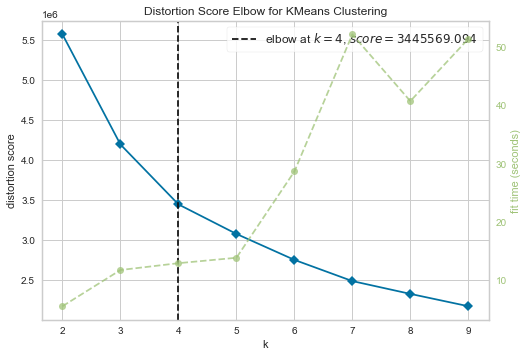

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
from sklearn.cluster import KMeans
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(data_standard)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

C:\Users\vardh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

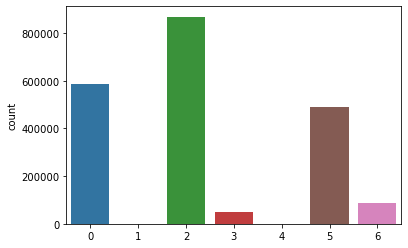

In [62]:
sns.countplot(cluster_labels)

In [63]:
data_all['label_cluster'] = cluster_labels

In [64]:
data_all

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,label_cluster
0,40.767937,-73.982155,40.765602,-73.964630,2
1,40.738564,-73.980415,40.731152,-73.999481,0
2,40.763939,-73.979027,40.710087,-74.005333,0
3,40.719971,-74.010040,40.706718,-74.012268,0
4,40.793209,-73.973053,40.782520,-73.972923,5
...,...,...,...,...,...
625129,40.725105,-74.003464,40.733643,-74.001251,0
625130,40.743782,-74.006363,40.782467,-73.953407,2
625131,40.759865,-73.972267,40.748665,-73.876602,2
625132,40.733562,-73.976501,40.891788,-73.854263,5


In [65]:
df['label_cluster'] = data_all.iloc[:len(df), 4]
test['label_cluster'] = data_all.iloc[len(df):, 4]

In [66]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_quarter,pickup_isweekend,pickup_isevents,pickup_dotm,pickup_woty,pickup_season,euclidean_distance,manhattan_distance,label_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,March,1,False,False,14,Week 11,Spring,0.017680,0.019859,2
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,June,2,True,False,12,Week 24,Summer,0.020456,0.026478,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,January,1,False,False,19,Week 03,Winter,0.059934,0.080158,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,April,2,False,False,06,Week 14,Spring,0.013438,0.015480,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,March,1,True,False,26,Week 12,Spring,0.010690,0.010818,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,0,...,April,2,False,False,08,Week 14,Spring,0.013791,0.018063,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,0,...,January,1,True,False,10,Week 02,Winter,0.057998,0.079929,5
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,0,...,April,2,False,False,22,Week 16,Spring,0.076327,0.106731,2
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,0,...,January,1,False,False,05,Week 01,Winter,0.010962,0.015491,2


In [67]:
test

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,...,euclidean_distance,manhattan_distance,haversine_distance,bearing,diff_longitude,diff_latitude,centre_longitude,centre_latitude,angle,label_cluster
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2016-06-30,...,0.024735,0.026695,2.746426,-3.595224,0.002045,-0.024651,-73.989151,40.744354,-3.595224,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2016-06-30,...,0.024979,0.028984,2.759239,172.278835,-0.004395,0.024590,-73.962006,40.667698,172.278835,6
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,2016-06-30,...,0.013861,0.019337,1.306155,133.326248,-0.011276,0.008060,-73.991798,40.733553,133.326248,0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,2016-06-30,...,0.051363,0.071789,5.269088,-150.956833,0.030357,0.041431,-73.971249,40.751184,-150.956833,2
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,2016-06-30,...,0.010343,0.014290,0.960842,130.260381,-0.008705,0.005585,-73.965862,40.758682,130.260381,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,0,2016-01-01,...,0.008819,0.010750,0.967438,11.110268,-0.002213,-0.008537,-74.002357,40.729374,11.110268,0
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,0,2016-01-01,...,0.065581,0.091640,6.196343,46.018484,-0.052956,-0.038685,-73.979885,40.763124,46.018484,2
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,0,2016-01-01,...,0.096318,0.106865,8.153719,98.754367,-0.095665,0.011200,-73.924435,40.754265,98.754367,2
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,0,2016-01-01,...,0.199944,0.280464,20.380748,30.275237,-0.122238,-0.158226,-73.915382,40.812675,30.275237,5


In [36]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'pickup_date',
       'check_trip_duration', 'pickup_dotw', 'pickup_month', 'pickup_quarter',
       'pickup_isweekend', 'pickup_isevents', 'pickup_dotm', 'pickup_woty',
       'pickup_season', 'euclidean_distance', 'manhattan_distance',
       'haversine_distance', 'bearing', 'diff_longitude', 'diff_latitude',
       'centre_longitude', 'centre_latitude', 'angle', 'label_cluster'],
      dtype='object')

## Modelling

### Using the well-known classification model Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

#df.drop('id',axis=1,inplace=True)
#df.drop('pickup_datetime',axis=1,inplace=True)
#test.drop('id',axis=1,inplace=True)
#test.drop('pickup_datetime',axis=1,inplace=True)
X_train = df.drop('label_cluster',axis=1)
Y_train = df['label_cluster']
clf = LogisticRegression(random_state=42).fit(X_train, Y_train)
X_test = test.drop('label_cluster',axis=1)
Y_test = test['label_cluster']
Y_preds = clf.predict(X_test)

ValueError: could not convert string to float: 'Monday'

In [ ]:
Y_preds